In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import starfish

## Reproduce decoding of an ISS tile from starfish pipeline by following [starfish's ISS notebook](https://github.com/spacetx/starfish/blob/master/notebooks/ISS.ipynb)

* Load ISS data from starfish

In [2]:
from starfish import data, FieldOfView 
experiment = data.ISS(use_test_data=False)
# i = '00' #select fov \in {00,01,...,15}
# fov = experiment['fov_0'+i]
fov = experiment.fov()
imgs = fov.get_image(FieldOfView.PRIMARY_IMAGES)
dots = fov.get_image("dots")
nuclei = fov.get_image("nuclei")

* Filter and register ISS data using starfish pipline

In [3]:
from starfish.image import Filter
from starfish.image import ApplyTransform, LearnTransform
from starfish.types import Axes

masking_radius = 5
filt = Filter.WhiteTophat(masking_radius, is_volume=False)
filtered_imgs = filt.run(imgs, verbose=True, in_place=False)
filt.run(dots, verbose=True, in_place=True)

learn_translation = LearnTransform.Translation(reference_stack=dots, axes=Axes.ROUND, upsampling=1000)
transforms_list = learn_translation.run(imgs.reduce({Axes.CH, Axes.ZPLANE}, func="max"))
warp = ApplyTransform.Warp()
registered_imgs = warp.run(filtered_imgs, transforms_list=transforms_list, in_place=False, verbose=True)

100%|██████████| 4/4 [00:00<00:00, 124.23it/s]


* Detect spots via starfish's BlobDetector with its default parameters

In [4]:
import warnings
from starfish.spots import FindSpots, DecodeSpots
from starfish.types import FunctionSource
bd = FindSpots.BlobDetector(
    min_sigma=1,
    max_sigma=10,
    num_sigma=30,
    threshold=0.01,
    measurement_type='mean',
)
spot_detector = bd # select which spot detector to execute
dots_max = dots.reduce((Axes.ROUND, Axes.ZPLANE), func=FunctionSource.np("max"))#same as dots above since there's only one (reference) round for the anchor channel
spots_starfish = spot_detector.run(image_stack=registered_imgs, reference_image=dots_max)#detecting spots in the anchor channel from the reference round

100%|██████████| 1/1 [00:00<00:00, 215.75it/s]


* Decode spots via starfish's PerRoundMaxChannel (argmax)

In [5]:
from starfish.types import Features
decoder = DecodeSpots.PerRoundMaxChannel(codebook=experiment.codebook)
decoded = decoder.run(spots=spots_starfish)
genes, counts = np.unique(decoded.loc[decoded[Features.PASSES_THRESHOLDS]][Features.TARGET], return_counts=True)
table = pd.Series(counts, index=genes).sort_values(ascending=False)

* Plot starfish decoding results in a histogram

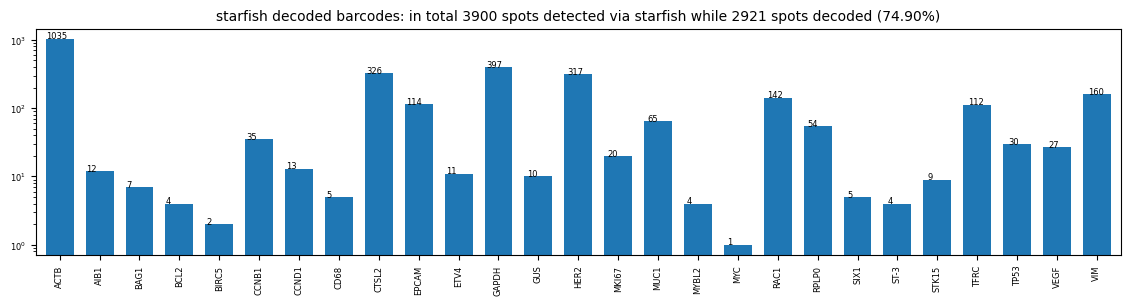

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(14,3), dpi=100, facecolor='w', edgecolor='k')
table.sort_index(axis=0).plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=6,ax=ax)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('starfish decoded barcodes: in total {} spots detected via starfish while {} spots decoded ({:.02f}%)'.format(list(spots_starfish.values())[0].spot_attrs.data.spot_id.size,counts.sum(),100*counts.sum()/list(spots_starfish.values())[0].spot_attrs.data.spot_id.size),fontsize=10)       
plt.show()

# PoSTcode

## 1) PoSTcode's decoding of starfish's spots

* Collect spots, spots_loc and barcodes from starfish in the required numpy format for PoSTcode

In [7]:
from starfish.core.spots.DecodeSpots.trace_builders import build_spot_traces_exact_match
bd_table = build_spot_traces_exact_match(spots_starfish)
spots_s = np.swapaxes(bd_table.data,1,2)
N = spots_s.shape[0]
spots_loc_s = pd.DataFrame(columns=['X', 'Y'])
spots_loc_s['X'] = np.array(bd_table.x)
spots_loc_s['Y'] = np.array(bd_table.y)
barcodes_01 = np.swapaxes(np.array(experiment.codebook), 1, 2)
K = barcodes_01.shape[0]

* Estimate PoSTcode's parameters and compute class probabilities

In [8]:
from postcode.decoding_functions import *
out = decoding_function(spots_s, barcodes_01, print_training_progress=True)

100%|██████████| 257/257 [00:00<00:00, 1297.18it/s]


* Create a data frame from the decoding output

In [9]:
df_class_names = np.concatenate((experiment.codebook.target.values,['infeasible','background','nan']))
barcodes_0123 = np.argmax(np.array(experiment.codebook),axis=2)
channel_base=['T', 'G', 'C', 'A']
barcodes_AGCT = np.empty(K, dtype='object')
for k in range(K):
    barcodes_AGCT[k]=''.join(list(np.array(channel_base)[barcodes_0123[k,:]]))
df_class_codes = np.concatenate((barcodes_AGCT,['NA','0000','NA']))
decoded_spots_df = decoding_output_to_dataframe(out, df_class_names, df_class_codes)
decoded_df_s = pd.concat([decoded_spots_df, spots_loc_s], axis=1) 

* Plot loss, estimated activation parameters and covariance, as well as the histogram of barcode assignments

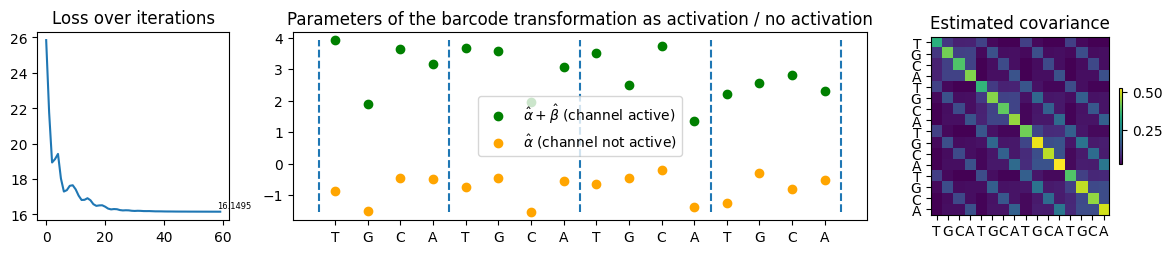

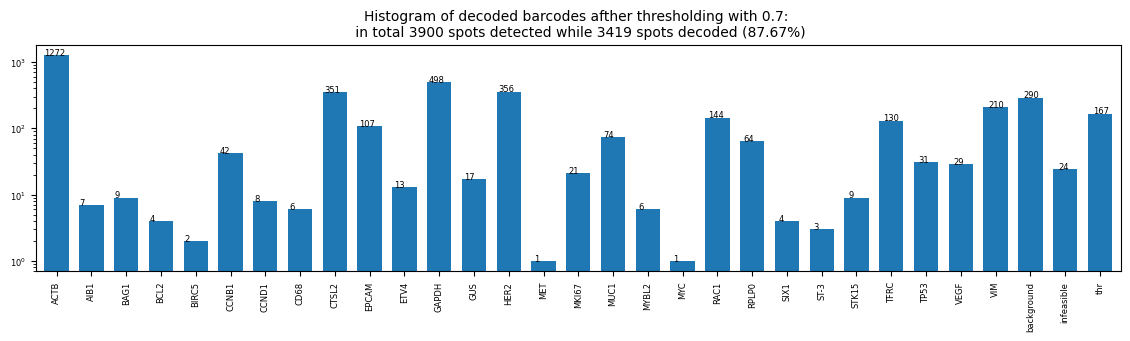

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 3, 1]}, figsize=(14, 2.5), dpi=100, facecolor='w', edgecolor='k')
R = imgs.shape['r']
C = imgs.shape['c']
activation = (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star'])[0,:].numpy() #corresponding to the channel activation (code=1)
no_activation = out['params']['codes_tr_consts_v_star'][0,:].numpy() # (code=0)
channel_activation=np.stack((no_activation,activation))
ax1.plot(np.arange(0,len(out['params']['losses'])),(1/out['class_probs'].shape[0]*np.asarray(out['params']['losses'])))
ax1.annotate(np.round(1/out['class_probs'].shape[0]*out['params']['losses'][-1],4),(-2+len(out['params']['losses']),0.2+1/out['class_probs'].shape[0]*out['params']['losses'][-1]),size=6)
ax1.set_title('Loss over iterations')
ax2.scatter(np.arange(1,1+R*C),activation,c='green',label=r'$\hat{\alpha}+\hat{\beta}$ (channel active)') 
ax2.scatter(np.arange(1,1+R*C),no_activation,c='orange',label=r'$\hat{\alpha}$ (channel not active)') 
ax2.legend(loc=10)
ax2.vlines(np.arange(0.5,R*C+.8,C), out['params']['codes_tr_consts_v_star'].min(), (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star']).max(), linestyles='dashed')
ax2.set_xticks(np.arange(1,1+R*C))
ax2.set_xticklabels(np.tile(np.array(channel_base),R))
ax2.set_title('Parameters of the barcode transformation as activation / no activation')
covim = ax3.imshow(out['params']['sigma_star'])
ax3.set_xticks(np.arange(0,R*C))
ax3.set_xticklabels(np.tile(np.array(channel_base),R))
ax3.set_yticks(np.arange(0,R*C))
ax3.set_yticklabels(np.tile(np.array(channel_base),R))
ax3.set_title('Estimated covariance')
plt.colorbar(covim, ax=ax3, fraction=0.02)
plt.show()

thr=0.7
df = pd.concat([decoded_df_s.Name[decoded_df_s.Probability>thr].value_counts(), decoded_df_s.Name[decoded_df_s.Probability <=thr].replace(np.unique(decoded_df_s.Name),'thr').value_counts()]).sort_index(axis=0)#.sort_values(ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(14,3), dpi=100, facecolor='w', edgecolor='k')
df.plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=6,ax=ax)
num_decoded_barcodes = sum((decoded_df_s.Name!='background')&(decoded_df_s.Name!='infeasible')&(decoded_df_s.Name!='NaN')&(decoded_df_s.Probability>thr))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('Histogram of decoded barcodes afther thresholding with {}: \n in total {} spots detected while {} spots decoded ({:.02f}%)'.format(thr,decoded_df_s.shape[0], num_decoded_barcodes , 100*num_decoded_barcodes/ decoded_df_s.shape[0]),fontsize=10)       
plt.show()

* Compare histograms side by side on the spots detected via starfish

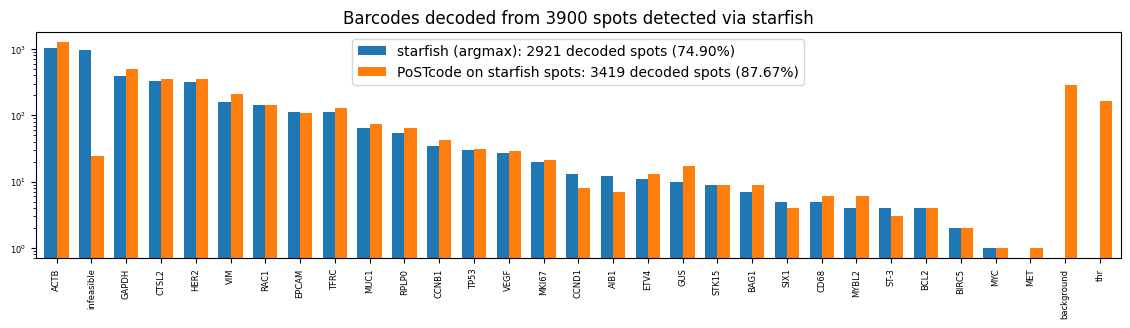

In [11]:
df_together= pd.DataFrame(columns=['starfish','PoSTcode_s'],index=df.index)
df_together['PoSTcode_s']=pd.concat([decoded_df_s.Name[decoded_df_s.Probability>0.7].value_counts(), decoded_df_s.Name[decoded_df_s.Probability <=0.7].replace(np.unique(decoded_df_s.Name),'thr').value_counts()]).sort_index(axis=0)
df_together['starfish']=table.append(pd.Series(N-counts.sum(), index=['infeasible']))
df_together=df_together.fillna(0)
df_together=df_together.sort_values(by='starfish', ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(14,3), dpi=100, facecolor='w', edgecolor='k')
df_together.plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=6,ax=ax)
Npostcode_s=sum((decoded_df_s.Name!='background')&(decoded_df_s.Name!='infeasible')&(decoded_df_s.Name!='NaN')&(decoded_df_s.Probability>0.7))
ax.legend(["starfish (argmax): {} decoded spots ({:.02f}%)".format(counts.sum(),100*counts.sum()/list(spots_starfish.values())[0].spot_attrs.data.spot_id.size),
           "PoSTcode on starfish spots: {} decoded spots ({:.02f}%)".format(Npostcode_s,100*Npostcode_s/ N)])        
plt.title('Barcodes decoded from {} spots detected via starfish'.format(N))
plt.show()

## 2) PoSTcode's decoding of spots detected via PoSTcode's function 'detect_and_extract_spots' that wraps up trackpy

* Spot detection using anchor channel from the reference round and spot extraction from the coding channels

In [12]:
from postcode.spot_detection_functions import *
imgs_coding_np = np.swapaxes(np.array(registered_imgs.xarray.squeeze()).transpose(),0,1) #coding channels (H x W x C x R)
anchors = np.array(dots.xarray.squeeze()) #if to search spots on filtered anchor from the reference round (H x W)
#anchors = np.swapaxes(np.swapaxes(imgs_coding_np.max(axis=2), 0, 2), 1, 2) #if to search spots on max-projected channels in each round by tracking (R x H X W)
spots_tp, centers_tp, _, _ = detect_and_extract_spots(imgs_coding_np, anchors, C, R, trackpy_spot_diam=5, trackpy_prc=0, trackpy_sep=2)
spots_loc = pd.DataFrame(np.concatenate((centers_tp[:, 0].reshape((spots_tp.shape[0], 1)), centers_tp[:, 1].reshape((spots_tp.shape[0], 1))), axis=1), columns=['X', 'Y'], index=None)                 

* Estimate model parameters and create a data frame from the decoding output

In [13]:
out = decoding_function(spots_tp, barcodes_01, print_training_progress=True)
df_class_names = np.concatenate((experiment.codebook.target.values,['infeasible','background','nan']))
df_class_codes = np.concatenate((barcodes_AGCT,['NA','0000','NA']))
decoded_spots_df = decoding_output_to_dataframe(out, df_class_names, df_class_codes)
decoded_df = pd.concat([decoded_spots_df, spots_loc], axis=1) 

100%|██████████| 257/257 [00:00<00:00, 1269.79it/s]


* Plot loss, estimated activation parameters and covariance, as well as the histogram of barcode assignments

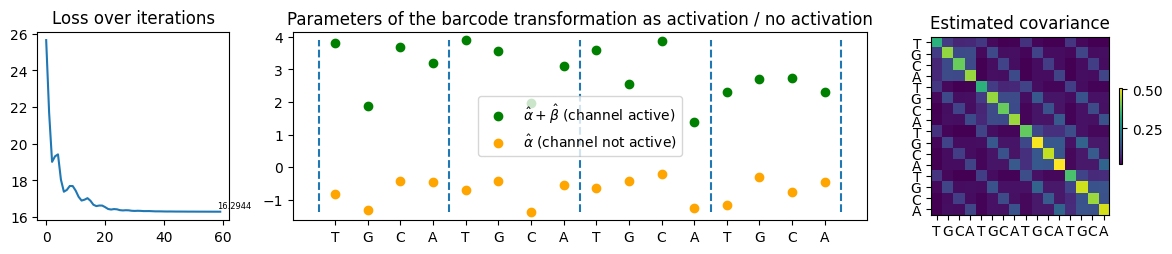

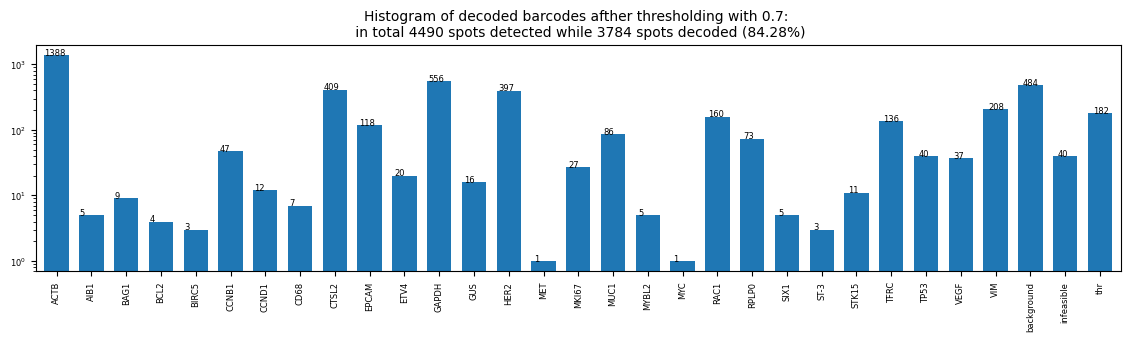

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw={'width_ratios': [1, 3, 1]}, figsize=(14, 2.5), dpi=100, facecolor='w', edgecolor='k')
R = imgs.shape['r']
C = imgs.shape['c']
activation = (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star'])[0,:].numpy() #corresponding to the channel activation (code=1)
no_activation = out['params']['codes_tr_consts_v_star'][0,:].numpy() # (code=0)
channel_activation=np.stack((no_activation,activation))
ax1.plot(np.arange(0,len(out['params']['losses'])),(1/out['class_probs'].shape[0]*np.asarray(out['params']['losses'])))
ax1.annotate(np.round(1/out['class_probs'].shape[0]*out['params']['losses'][-1],4),(-2+len(out['params']['losses']),0.2+1/out['class_probs'].shape[0]*out['params']['losses'][-1]),size=6)
ax1.set_title('Loss over iterations')
ax2.scatter(np.arange(1,1+R*C),activation,c='green',label=r'$\hat{\alpha}+\hat{\beta}$ (channel active)') 
ax2.scatter(np.arange(1,1+R*C),no_activation,c='orange',label=r'$\hat{\alpha}$ (channel not active)') 
ax2.legend(loc=10)
ax2.vlines(np.arange(0.5,R*C+.8,C), out['params']['codes_tr_consts_v_star'].min(), (out['params']['codes_tr_v_star']+out['params']['codes_tr_consts_v_star']).max(), linestyles='dashed')
ax2.set_xticks(np.arange(1,1+R*C))
ax2.set_xticklabels(np.tile(np.array(channel_base),R))
ax2.set_title('Parameters of the barcode transformation as activation / no activation')
covim = ax3.imshow(out['params']['sigma_star'])
ax3.set_xticks(np.arange(0,R*C))
ax3.set_xticklabels(np.tile(np.array(channel_base),R))
ax3.set_yticks(np.arange(0,R*C))
ax3.set_yticklabels(np.tile(np.array(channel_base),R))
ax3.set_title('Estimated covariance')
plt.colorbar(covim, ax=ax3, fraction=0.02)
plt.show()

thr=0.7
df = pd.concat([decoded_df.Name[decoded_df.Probability>thr].value_counts(), decoded_df.Name[decoded_df.Probability <=thr].replace(np.unique(decoded_df.Name),'thr').value_counts()]).sort_index(axis=0)#.sort_values(ascending=False)
fig, ax = plt.subplots(1, 1, figsize=(14,3), dpi=100, facecolor='w', edgecolor='k')
df.plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=6,ax=ax)
num_decoded_barcodes = sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>thr))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),size=6) 
plt.title('Histogram of decoded barcodes afther thresholding with {}: \n in total {} spots detected while {} spots decoded ({:.02f}%)'.format(thr,decoded_df.shape[0], num_decoded_barcodes , 100*num_decoded_barcodes/ decoded_df.shape[0]),fontsize=10)       
plt.show()

* Compare all three histograms side by side

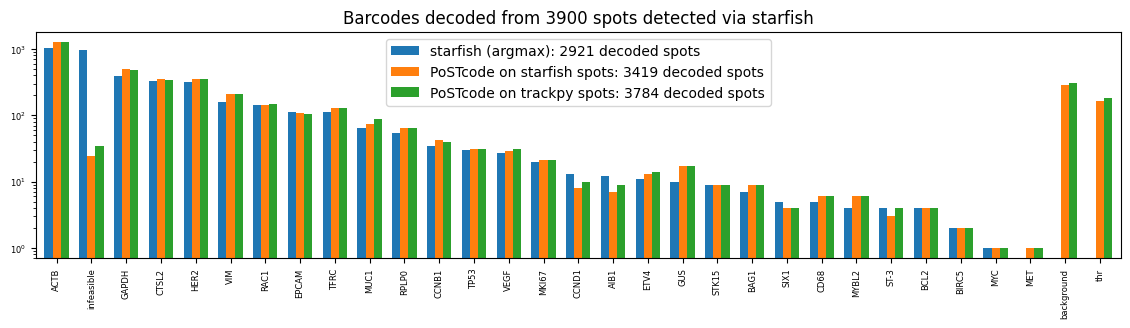

In [15]:
df_together['PoSTcode']=pd.concat([decoded_df_s.Name[decoded_df.Probability>0.7].value_counts(), decoded_df.Name[decoded_df.Probability <=0.7].replace(np.unique(decoded_df.Name),'thr').value_counts()]).sort_index(axis=0)
fig, ax = plt.subplots(1, 1, figsize=(14,3), dpi=100, facecolor='w', edgecolor='k')
df_together.plot(kind='bar',width=0.7,rot=90,logy=True,fontsize=6,ax=ax)
Npostcode=sum((decoded_df.Name!='background')&(decoded_df.Name!='infeasible')&(decoded_df.Name!='NaN')&(decoded_df.Probability>0.7))
ax.legend(["starfish (argmax): {} decoded spots".format(counts.sum()),
           "PoSTcode on starfish spots: {} decoded spots".format(Npostcode_s),
           "PoSTcode on trackpy spots: {} decoded spots".format(Npostcode)])  
plt.title('Barcodes decoded from {} spots detected via starfish'.format(N))
plt.show()

100%|██████████| 1/1 [00:00<00:00, 169.86it/s]


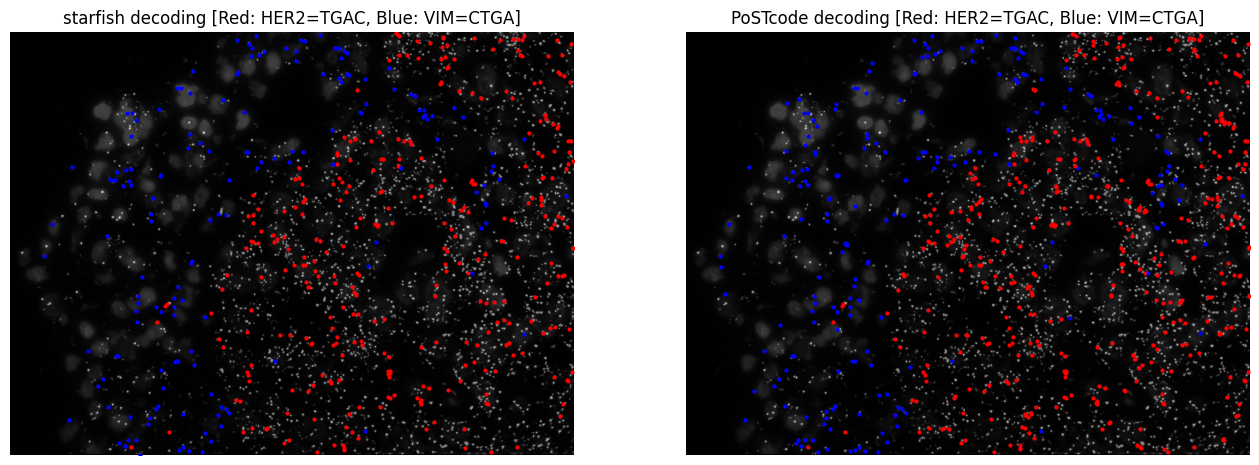

In [16]:
from skimage.color import rgb2gray

GENE1 = 'HER2'
GENE2 = 'VIM'

rgb = np.zeros(registered_imgs.tile_shape + (3,))
nuclei_numpy = nuclei.reduce({Axes.ROUND, Axes.CH, Axes.ZPLANE}, func="max")._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
rgb[:,:,0] = nuclei_numpy
dots_numpy = dots.reduce({Axes.ROUND, Axes.CH, Axes.ZPLANE}, func="max")._squeezed_numpy(Axes.ROUND, Axes.CH, Axes.ZPLANE)
rgb[:,:,1] = dots_numpy
do = rgb2gray(rgb)
do = do/(do.max())

plt.figure(num=None, figsize=(16, 8), dpi=100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
plt.imshow(do,cmap='gray')
plt.axis('off');
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    is_gene1 = decoded.where(decoded[Features.AXIS][Features.TARGET] == GENE1, drop=True)
    is_gene2 = decoded.where(decoded[Features.AXIS][Features.TARGET] == GENE2, drop=True)
plt.plot(is_gene1.x, is_gene1.y, 'or', markersize=2)
plt.plot(is_gene2.x, is_gene2.y, 'ob', markersize=2)
plt.title(f'starfish decoding [Red: {GENE1}={df_class_codes[df_class_names==GENE1][0]}, Blue: {GENE2}={df_class_codes[df_class_names==GENE2][0]}]');
plt.subplot(1, 2, 2)
plt.imshow(do,cmap='gray')
plt.axis('off');
thr = 0.7
x_coord_1 = decoded_df.X[(decoded_df.Name == GENE1) & (decoded_df.Probability >thr)]#.to_numpy(dtype=np.double)
y_coord_1 = decoded_df.Y[(decoded_df.Name == GENE1) & (decoded_df.Probability >thr)]#.to_numpy(dtype=np.double)
x_coord_2 = decoded_df.X[(decoded_df.Name == GENE2) & (decoded_df.Probability >thr)]#.to_numpy(dtype=np.double)
y_coord_2 = decoded_df.Y[(decoded_df.Name == GENE2) & (decoded_df.Probability >thr)]#.to_numpy(dtype=np.double)
plt.plot(x_coord_1, y_coord_1, 'or', markersize=2)
plt.plot(x_coord_2, y_coord_2, 'ob', markersize=2)
plt.title(f'PoSTcode decoding [Red: {GENE1}={df_class_codes[df_class_names==GENE1][0]}, Blue: {GENE2}={df_class_codes[df_class_names==GENE2][0]}]');